In [1]:
import sys
from PyQt5 import QtCore, QtWidgets
from PyQt5.QtWidgets import QMainWindow, QCheckBox,  QApplication, QWidget, QPushButton, QAction, QLineEdit, QMessageBox, QInputDialog, QLabel
from PyQt5.QtGui import *  
from PyQt5.QtCore import QSize 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import datetime as dt
import bs4 as bs
import pickle
import requests
import os
import re
import time
import numpy as np
from scipy.interpolate import UnivariateSpline
%matplotlib inline

style.use('default')

In [2]:
def create_csv(stock='TSLA',start=dt.datetime(2017,1,1),now = dt.datetime.now(),location = 'Unmodified'):
    
    '''This function takes values from yahoo finance and turns it into a pandas database, saving it as a csv in a folder'''

    #now = dt.datetime.now()
    end=dt.datetime(now.year,now.month,now.day)
    
    dataframe = web.DataReader(stock,'iex',start,end)
    
    TSLA = dataframe.to_csv('stock_dfs/{}/{}.csv'.format(str(location),str(stock)))

In [3]:
def read_csv(stock='TSLA',location = 'Unmodified'):
    
    '''This function reads the data from the csv stored by create_csv and adds some rolling averages and plots it all'''
    
    fit = plt.figure(figsize = [20,10])
    df=pd.read_csv('stock_dfs/{}/{}.csv'.format(location,stock),parse_dates=True,index_col=0)
    
    try:
        df['300ma']=df['Close'].rolling(window=300,min_periods=0).mean()
        df['100ma']=df['Close'].rolling(window=100,min_periods=0).mean()
        df['80ma']=df['Close'].rolling(window=80,min_periods=0).mean()
        df['40ma']=df['Close'].rolling(window=40,min_periods=0).mean()
        df['20ma']=df['Close'].rolling(window=20,min_periods=0).mean()
    except KeyError or TypeError:
        df['300ma']=df['close'].rolling(window=300,min_periods=0).mean()
        df['100ma']=df['close'].rolling(window=100,min_periods=0).mean()
        df['80ma']=df['close'].rolling(window=80,min_periods=0).mean()
        df['40ma']=df['close'].rolling(window=40,min_periods=0).mean()
        df['20ma']=df['close'].rolling(window=20,min_periods=0).mean()
    
    ax1=plt.subplot2grid((6,3),(0,0),rowspan=5,colspan=3,ylabel='Stock Price',title=stock)
    ax2=plt.subplot2grid((6,3),(5,0),rowspan=1,colspan=3,sharex=ax1)
    
    try:
        ax1.plot(df.index,df['Close'],color='k')
    except KeyError or TypeError:
        ax1.plot(df.index,df['close'],color='k')
    ax1.plot(df.index,df['300ma'],'--',label="300 day",alpha=.8)
    ax1.plot(df.index,df['100ma'],'--',label="100 day",alpha=.8)
    ax1.plot(df.index,df['40ma'],'--',label="40 day",alpha=.8)
    ax1.plot(df.index,df['20ma'],'--',label="20 day",alpha=.8)
    ax1.legend(loc='upper left')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    try:
        ax2.plot(df.index,df['Volume'],color='black')
    except:
        ax2.plot(df.index,df['volume'],color='black')
    df.to_csv('stock_dfs/{}/{}.csv'.format(location,stock))
    

In [4]:
def save_sp500_tickers():
    
    '''This function takes the S&P 500 list and creates csvs for each of them using beautiful soup'''
    
    resp=requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text,'lxml')
    table = soup.find('table',{'class':'wikitable sortable'})
    stock_names = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        stock_names.append(ticker)
            
    with open('sp500tickers.pickle','wb') as f:
        pickle.dump(stock_names,f)
        
    print(stock_names)
    
    return stock_names

In [5]:
def get_data_from_yahoo(reload_sp500=False):
    
    '''This reimports data for the S&P 500 companies if needed'''
    
    if reload_sp500==True:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle','rb') as f:
            tickers = pickle.load(f)
            
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    
    start=dt.datetime(2017,1,1)
    now = dt.datetime.now()
    end=dt.datetime(now.year,now.month,now.day)
    
    for ticker in tickers[:500]:
        time.sleep(2)
        try:
            if not os.path.exists('stock_dfs/Testing/{}.csv'.format(ticker)):
                df=web.DataReader(ticker,'iex',start,end)
                df.to_csv('stock_dfs/Testing/{}.csv'.format(ticker))
            #else:
                #print('Already have {}'.format(ticker))
        except:
            create_csv(ticker)

In [6]:
def testing(buying,selling,task='sum',stock='TSLA'):
    
    '''This is for testing when the rolling averages are profitable, mostly just for testing'''
       
    buy_stock=[]
    sell_stock=[]
    sum_total=0
    buying=str(buying)
    selling=str(selling)
    
    Previous_adj_close=0
    sell_if_can=False
    buy_now = False
    sell_now = False
        
    df=pd.read_csv('stock_dfs/Testing/{}.csv'.format(stock),parse_dates=True,index_col=0)
    try:
        df['100ma']=df['Close'].rolling(window=100,min_periods=0).mean()
        df['80ma']=df['Close'].rolling(window=80,min_periods=0).mean()
        df['40ma']=df['Close'].rolling(window=40,min_periods=0).mean()
        df['20ma']=df['Close'].rolling(window=20,min_periods=0).mean()
    except KeyError or TypeError:
        df['100ma']=df['close'].rolling(window=100,min_periods=0).mean()
        df['80ma']=df['close'].rolling(window=80,min_periods=0).mean()
        df['40ma']=df['close'].rolling(window=40,min_periods=0).mean()
        df['20ma']=df['close'].rolling(window=20,min_periods=0).mean()
    
    for index,row in df.iterrows():
        buy_new = False
        sell_now = False
        try:
            Current_adj_close=row['Close']
        except KeyError or TypeError:
            Current_adj_close=row['close']
        if row[buying+'ma']<Previous_adj_close and row[buying+'ma']>Current_adj_close and row[selling+'ma']<row[buying+'ma'] and sell_if_can==False:
            buy_stock.append(Current_adj_close)
            sell_if_can = True
            buy_new = True
        if sell_if_can==True and row[selling+'ma']>Previous_adj_close and row[selling+'ma']<Current_adj_close and row[selling+'ma']>buy_stock[-1]:
            sell_stock.append(Current_adj_close)
            sell_if_can=False
            sell_now=True
        Previous_adj_close=Current_adj_close

    for i in range(0,len(buy_stock)):
        try:
            #print(sell_stock[i]-buy_stock[i])
            sum_total+=sell_stock[i]-buy_stock[i]
        except IndexError:
            pass
    #print(sum_total)
    if buy_now:
        print('yay')
    if task == 'sum':
        return sum_total
    elif task == 'trade':
        return buy_now,sell_now

In [7]:
def add_double_derivative(stock='TSLA'):
    
    '''More testing to see if numerical integration could be useful for finding trends'''
    #This doesn't work properly, fix it later
    
    df=pd.read_csv('stock_dfs/{}.csv'.format(stock),parse_dates=True,index_col=0)
    
    previous_row = df.iloc[0]
    previous_previous_row = df.iloc[0] 
    
    for index,row in df.iterrows():
        #print(previous_previous_row['Adj Close'],previous_row['Adj Close'],row['Adj Close'])
        df['double_derivative']=(float(previous_previous_row['Close'])-2*float(previous_row['Close'])+float(row['Close']))/4
        previous_previous_row=previous_row
        previous_row=row
    #print(df)

In [8]:
def record_testing_results():
    
    '''When testing, we want to output the results to a csv'''
    
    df=pd.DataFrame(columns = ['Stock','100ma - 20ma','100ma - 40ma','40ma - 20ma'])
    
    for file in os.listdir('stock_dfs/Testing/'):
        list_dict=[]
        if file.endswith(".csv") and file!='rolling_average_testing.csv':
            stock = file[:file.find('.')]
            list_dict.append(stock)
            #print(stock)
            list_dict.append(testing(100,20,stock))
            list_dict.append(testing(100,40,stock))
            list_dict.append(testing(40,20,stock))
            df.loc[len(df)]=list_dict
    df.to_csv('stock_dfs/rolling_average_testing.csv')

In [9]:
def add_values():
    
    '''This is so we dont have to keep reimporting data everytime to view a dataset and only need to import a section of it'''
    
    for file in os.listdir('stock_dfs/Testing/'):
        if file.endswith(".csv") and file!='rolling_average_testing.csv':
            stock = file[:file.find('.csv')]
            try:
                df = pd.read_csv('stock_dfs/Testing/'+str(file),parse_dates=True)
            except:
                print(stock)
                create_csv(stock,dt.datetime(2017,1,1),dt.datetime.now(),'Testing')
                df = pd.read_csv('stock_dfs/Testing/'+str(file),parse_dates=True)
            try:
                last_item = pd.to_datetime(df['Date'].loc[len(df['Date'])-1])
            except KeyError:
                create_csv(stock,dt.datetime(2017,1,1),dt.datetime.now(),'Testing')
                
                continue
            start = last_item
            
            now = dt.datetime.now()
            end=dt.datetime(now.year,now.month,now.day)
            if not end.weekday():
                end = end - dt.timedelta(days=1)
                if not end.weekday():
                    end = end - dt.timedelta(days=1)
            if start+ dt.timedelta(days=1) >= end:
                
                continue
            start =  start + dt.timedelta(days=1)
            start = start.date()
            end = end.date()
            try:
                dataframe = web.DataReader(stock,'iex',start,end)
            except:
                dataframe = web.DataReader(stock,'iex',start,end)
            dataframe['Date']=dataframe.index
            dataframe['Date'] = pd.to_datetime(dataframe['Date']).dt.date
            try:
                df = pd.concat([df,dataframe],ignore_index = True)
            except ValueError:
                print(stock,"Has a problem to it")
                break
            #print(df)
            thing = df.to_csv('stock_dfs/Testing/{}.csv'.format(stock))
            break

In [10]:
def iterate_stocks():
    '''This function will iterate over all the csvs and tell you which ones you should sell now or buy now'''
    
    for file in os.listdir('stock_dfs/Testing/'):
        if file.endswith(".csv") and file!='rolling_average_testing.csv':
            stock = file[:file.find('.csv')]
            buy_now,sell_now = testing('40','20','trade',stock)
            if buy_now:
                print("Buy {}".format(stock))
                read_csv(stock,'Testing')
                plt.show()
            if sell_now:
                print("Sell {}".format(stock))
                read_csv(stock,'Testing')
                plt.show()
            

In [11]:
import csv
import datetime
import re

import pandas as pd
import requests

def get_google_finance_intraday(ticker, period=300, days=60):
    """
    Retrieve intraday stock data from Google Finance.
    Parameters
    ----------
    ticker : str
        Company ticker symbol.
    period : int
        Interval between stock values in seconds.
    days : int
        Number of days of data to retrieve.
    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing the opening price, high price, low price,
        closing price, and volume. The index contains the times associated with
        the retrieved price values.
    """

    uri = 'https://finance.google.com/finance/getprices' \
          '?i={period}&p={days}d&f=d,o,h,l,c,v&df=cpct&q={ticker}'.format(ticker=ticker,
                                                                          period=period,
                                                                          days=days)
    page = requests.get(uri)
    reader = csv.reader(page.text.splitlines())
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    rows = []
    times = []
    for row in reader:
        if re.match('^[a\d]', row[0]):
            if row[0].startswith('a'):
                start = datetime.datetime.fromtimestamp(int(row[0][1:]))
                times.append(start)
            else:
                times.append(start+datetime.timedelta(seconds=period*int(row[0])))
            rows.append(map(float, row[1:]))
    if len(rows):
        return pd.DataFrame(rows, index=pd.DatetimeIndex(times, name='Date'),
                            columns=columns)
    else:
        return pd.DataFrame(rows, index=pd.DatetimeIndex(times, name='Date'))

In [12]:
def collect_data(ticker):
    
    if ticker+'.csv' in os.listdir('../../stored_data'): 
        df = get_google_finance_intraday(ticker,300)
    else:
        pass

2y


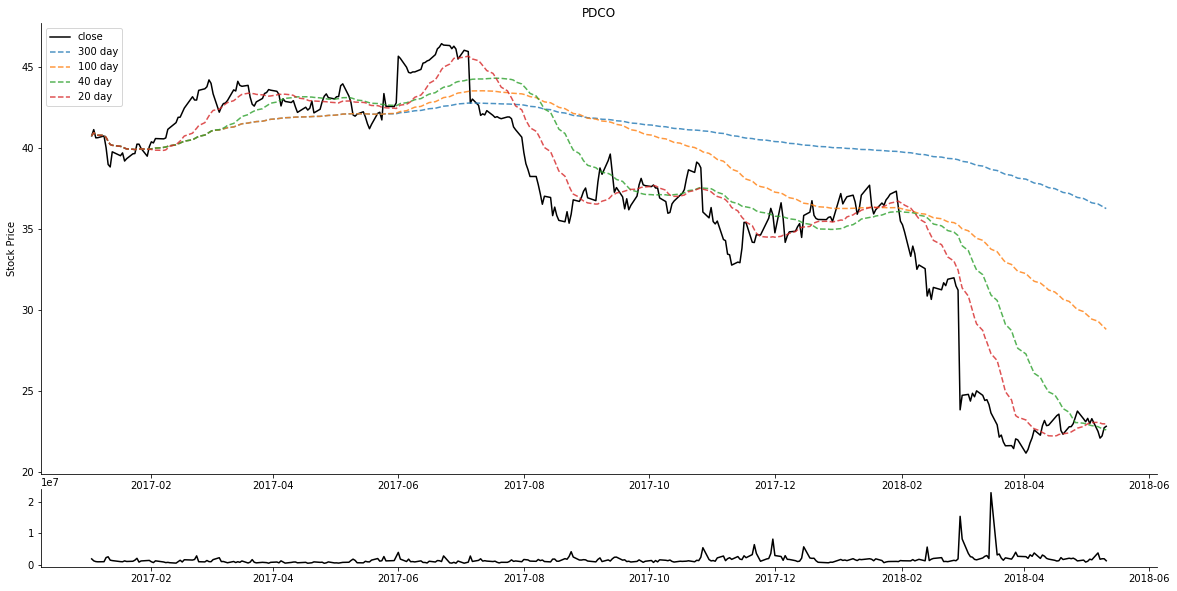

In [19]:
def main(name):
    
    name=str(name)
    start=dt.datetime(2017,1,1)
    end = dt.datetime.now()
    
    #get_data_from_yahoo(True)
    
    create_csv(name,start,end,'Testing')
    read_csv(name,'Testing')
    #plt.show()
    #testing_100ma_20ma(name)
    #testing_100ma_40ma(name)
    #testing_40ma_20ma(name)
    #add_double_derivative(name) #Fix this
    #record_testing_results()
    #add_values()
    #iterate_stocks()
    
    
try:
    stock = 'PDCO'
    main(stock)
except:
    main(stock)

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
    
def add_rolling_average(df,n):
    '''This is a general function that makes a rolling average over n
    data points'''
    
    df['{}ma'.format(n)]=df['Close'].rolling(window=n*12,min_periods=0).mean()
    return df

def testing_rolling_data(df):
    
    rows = []
    for i in range(5,60,5):
        columns = []
        for j in range(5,60,5):
            if i>=j:
                columns.append(0)
                continue
            df1 = df
            df1 = add_rolling_average(df1,i)
            df1 = add_rolling_average(df1,j)
            columns.append(check_rolling_returns(df1,i,j))
        rows.append(columns)
        
    plt.imshow(rows)
    plt.colorbar()
    plt.show()
    
    return rows,pos
            
def check_rolling_returns(df,buying,selling):
    
    buy_stock = []
    sell_stock = []
    Previous_adj_close=0
    sell_if_can=False
    sum_total = 0
    
    for index,row in df.iterrows():
        
        Current_adj_close=row['Close']
        
        if row['{}ma'.format(buying)]<Previous_adj_close and row['{}ma'.format(buying)]>\
        Current_adj_close and row['{}ma'.format(selling)]<row['{}ma'.format(buying)] and \
        sell_if_can==False:
            
            buy_stock.append(Current_adj_close)
            sell_if_can = True
            
        if sell_if_can==True and row['{}ma'.format(selling)]>Previous_adj_close and \
        row['{}ma'.format(selling)]<Current_adj_close and row['{}ma'.format(selling)]>buy_stock[-1]:
            sell_stock.append(Current_adj_close)
            sell_if_can=False
        Previous_adj_close=Current_adj_close

    sell_stock.append(Current_adj_close)

    for i in range(0,len(buy_stock)):
        
        sum_total+=sell_stock[i]-buy_stock[i]
        
    return round(sum_total,3)

def main():
    
    for file in os.listdir("../../stored_data/"):
        if file.endswith(".csv"):
            ticker = file[:file.find(".csv")]
            df = pd.read_csv('../../stored_data/{}.csv'.format(ticker))
            return testing_rolling_data(df)
            #df = add_rolling_average(df,20)
            #df = add_rolling_average(df,40)
            #df = add_rolling_average(df,60)
            #df = add_rolling_average(df,80)
            #df = add_rolling_average(df,100)

In [24]:
rows,pos = main()

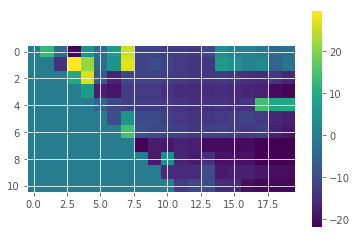

In [25]:
plt.imshow(rows)
plt.colorbar()

In [26]:
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in rows]))

   012.82-3.37-21.255.089-3.2416.63225.817-11.31-11.31-12.255-12.349-13.265-10.8754.0110.6310.968-0.695-3.819-3.004
   0   0-14.3729.88821.762-4.14.3827.263-11.78-10.25-11.706-13.06-13.975-13.565.934.721.072.196-5.459-2.242
   0   0   09.12827.196-7.895-16.785-10.935-11.355-11.355-12.49-13.284-14.07-13.465-12.955-14.015-14.803-15.485-13.663-16.258
   0   0   0   06.59-17.61-19.01-12.73-13.15-13.15-14.286-15.079-15.865-15.26-14.75-15.81-16.598-17.28-20.405-21.1
   0   0   0   0   0-5.451-10.515-11.83-12.25-12.25-13.385-14.179-14.965-14.36-13.85-14.855-14.16114.6938.7059.44
   0   0   0   0   0   0-9.244.973-9.98-9.98-12.026-13.44-14.225-13.62-13.11-12.368-11.598-13.26-16.385-17.49
   0   0   0   0   0   0   014.378-8.82-10.55-11.386-12.204-13.74-12.005-11.495-12.555-13.343-12.055-17.37-18.475
   0   0   0   0   0   0   0   0-21.442-18.066-18.422-17.015-17.333-20.445-20.445-20.445-20.445-21.945-21.945-21.945
   0   0   0   0   0   0   0   0   0-18.1873.572-16.611-17.727-14.777-19.353-19.